# Best Directors to work with

## Introduction

This notebook is focused on building data to support a recommendation for some directors that have created highly rated movies. The client company can then leverage this data to assist with choosing a director to hire. 

## Imports and necessary variables

In [172]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="white", context="talk")
rs = np.random.RandomState(8)
%matplotlib inline
conn = sqlite3.connect('data/im.db')
cur = conn.cursor()


## Average ratings and number of votes for all movies
In the following function we ran a query to see all the `movie_id` within the `im.db` database that has an average rating of 8 or higher and 5000 or more votes. 

In [19]:
pd.read_sql("""
SELECT * 
  FROM movie_ratings
  where averagerating >= 8 AND numvotes >= 5000
""", conn)







,movie_id,averagerating,numvotes
0,tt1663202,8.0,621193
1,tt8108198,8.5,43409
2,tt1201607,8.1,691835
3,tt1255953,8.3,124156
4,tt1649431,8.2,5707
...,...,...,...
207,tt1424432,8.6,55318
208,tt1821700,8.1,28950
209,tt4154756,8.5,670926
210,tt3569782,8.3,8484


## Query for basic movie data
In the following function we ran a query to see `movie_id` , `primary_title` , `original_title` , `genres` from the `movie_basics` table in the `im.db` database.

In [18]:
pd.read_sql("""
SELECT movie_id , primary_title , original_title , genres
    FROM movie_basics
""", conn)

,movie_id,primary_title,original_title,genres
0,tt0063540,Sunghursh,Sunghursh,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,"Comedy,Drama,Fantasy"
...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,Comedy
146142,tt9916730,6 Gunn,6 Gunn,None


## Query for directors with most movie making experience
In the following function we ran a query to see `person_id` , `primary_name` and `"Movies Made"` using several tables in the `im.db` database. We then grouped them by `person_id` and ordered them by the `"Movies Made"` alias in a descending order from most to least.

In [324]:
top_20_movies_made_directors = """
SELECT person_id , primary_name as Director , COUNT(directors.movie_id) as "Movies Made"  
    FROM persons
    JOIN directors 
      USING (person_id)
    JOIN movie_basics
      USING (movie_id)
    GROUP BY person_id
    ORDER BY "Movies Made" DESC
    
;
"""
pd.read_sql(top_20_movies_made_directors, conn).head(20)

,person_id,Director,Movies Made
0,nm6935209,Tony Newton,238
1,nm2563700,Jason Impey,190
2,nm1546474,Shane Ryan,185
3,nm3877467,Ruben Rodriguez,180
4,nm3848412,Sam Mason-Bell,144
5,nm6078996,Martin Sonntag,135
6,nm4341114,Dustin Ferguson,121
7,nm4921301,Gav Chuckie Steel,119
8,nm3079464,Corey Norman,114
9,nm4542885,Evan Marlowe,101


## Graph for Directors with most movies

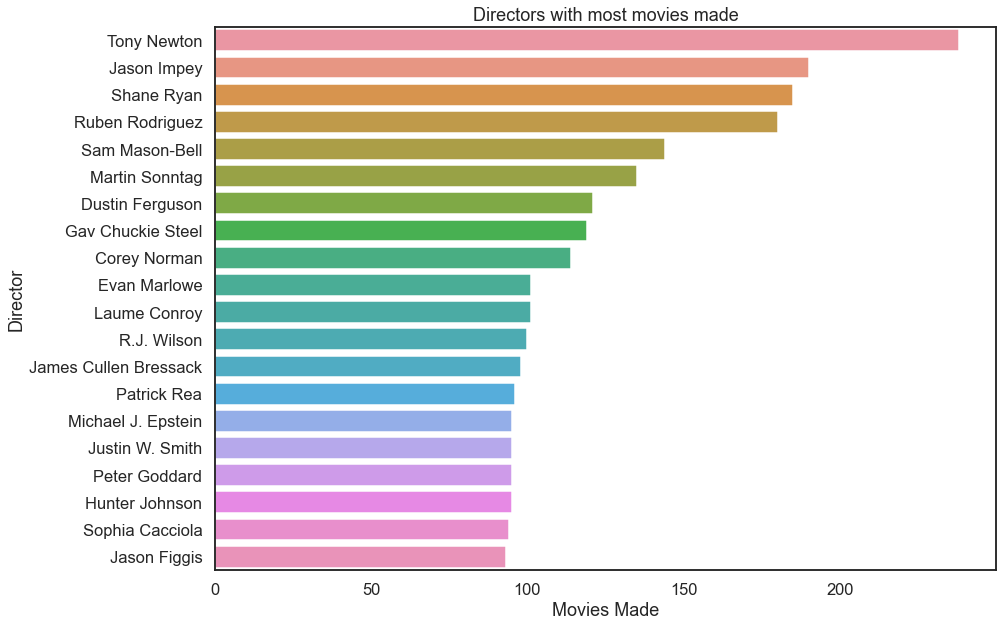

In [326]:
most_movies_director=pd.read_sql(top_20_movies_made_directors, conn).head(20)
fig = plt.subplots(figsize = (14,10))
sns.barplot(data= most_movies_director, x="Movies Made" , y="Director", orient="h")
plt.title("Directors with most movies made")
plt.show()

## Query for Top 20 Directors with high average rating as well as high vote counts
In the following function we ran a query to see what directors have a overall high average rating about 7 as well as a high number of votes to eliminate high rating but low voting outliers. We organized it into a top 20 by average rating of their movies made in descending order from highest to lowest.   

In [331]:
avg_rating = """
SELECT person_id , primary_name as Director , COUNT(DISTINCT directors.movie_id) as "MoviesMade", 
sum(movie_ratings.averagerating) / COUNT(movie_ratings.averagerating) as "Average Rating"
, movie_ratings.numvotes as numvotes 
    FROM persons
    JOIN directors 
      USING (person_id)
    JOIN movie_basics
      USING (movie_id)
    JOIN movie_ratings
      USING (movie_id)
    GROUP BY person_id 
    HAVING "Average Rating" >= 7.0 AND numvotes >= 400000
    ORDER BY "Average Rating" DESC
    LIMIT 20
    
;
"""
pd.read_sql(avg_rating, conn)

,person_id,Director,MoviesMade,Average Rating,numvotes
0,nm0000233,Quentin Tarantino,4,8.700000,1211405
1,nm0634240,Christopher Nolan,4,8.437500,1299334
2,nm0881279,Lee Unkrich,2,8.350000,682218
3,nm0751648,Joe Russo,4,8.246667,666252
4,nm0751577,Anthony Russo,4,8.246667,666252
5,nm0215455,Ronnie Del Carmen,1,8.200000,536181
6,nm1783265,Tim Miller,1,8.000000,820847
7,nm0154716,Stephen Chbosky,2,8.000000,422671
8,nm0230032,Pete Docter,2,7.977778,536181
9,nm0213450,Dean DeBlois,3,7.940000,611299


## Graph for Top 20 Directors with high average rating as well as high vote counts

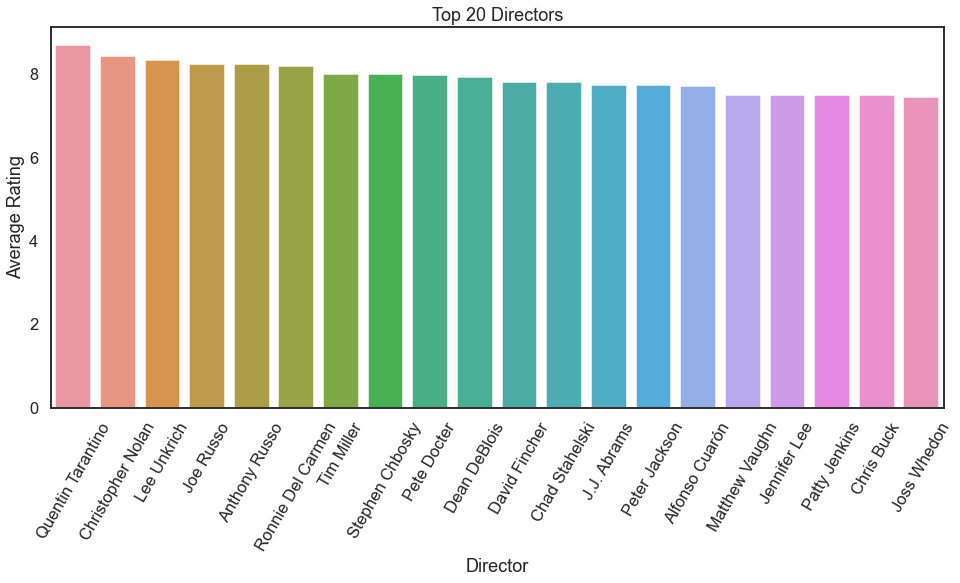

In [363]:
top_20_directors = pd.read_sql(avg_rating , conn) 
fig = plt.subplots(figsize = (16,7))
sns.barplot(data=top_20_directors, x="Director" , y="Average Rating")
plt.xticks(rotation=60)
plt.title("Top 20 Directors")

plt.show()

## Query for individual director with average rating of 7 or higher
In the following function we ran a query to see an individual Director with their movie titles and average ratings. As an example we used Director `Joe Russo` who has 4 movies in the database with a score of 7 or higher. In order to query a different director you just change out the Directors name in the line of code that says `WHERE Director Like 'Joe Russo'` to another director. It is also possible to change the rating as well. 

In [261]:
Director = """
SELECT directors.person_id , persons.primary_name as Director,  movie_basics.primary_title as "Movie Name" ,  movie_ratings.averagerating as "Average Rating" 
FROM principals 
JOIN persons
      USING (person_id)
JOIN movie_basics
      USING (movie_id)
JOIN directors 
      USING (person_id)
      JOIN movie_ratings
      USING (movie_id)
WHERE Director LIKE 'Joe Russo' AND averagerating >= 7
GROUP BY movie_basics.primary_title
ORDER BY movie_ratings.averagerating DESC
"""
pd.read_sql(Director, conn)


,person_id,Director,Movie Name,Average Rating
0,nm0751648,Joe Russo,Avengers: Endgame,8.8
1,nm0751648,Joe Russo,Avengers: Infinity War,8.5
2,nm0751648,Joe Russo,Captain America: The Winter Soldier,7.8
3,nm0751648,Joe Russo,Captain America: Civil War,7.8


## Query for top 20 Director in terms of votes and the categories of the films 

In [346]:
df4=pd.read_sql("""
SELECT movie_basics.genres AS Category, movie_ratings.averagerating AS Rating , movie_basics.movie_id , persons.primary_name AS Directors
, movie_basics.primary_title 
  FROM movie_basics
  INNER JOIN movie_ratings ON movie_basics.movie_id = movie_ratings.movie_id
  INNER JOIN directors ON movie_basics.movie_id = directors.movie_id
  INNER JOIN persons ON directors.person_id = persons.person_id
  WHERE movie_ratings.numvotes >= 600000 
  GROUP BY movie_basics.movie_id
  ORDER BY persons.primary_name
  LIMIT 20
""", conn)
df4

,Category,Rating,movie_id,Directors,primary_title
0,"Action,Adventure,Biography",8.0,tt1663202,Alejandro G. Iñárritu,The Revenant
1,"Drama,Sci-Fi,Thriller",7.7,tt1454468,Alfonso Cuarón,Gravity
2,"Action,Adventure,Sci-Fi",7.8,tt1843866,Anthony Russo,Captain America: The Winter Soldier
3,"Action,Adventure,Sci-Fi",8.5,tt4154756,Anthony Russo,Avengers: Infinity War
4,"Action,Adventure,Sci-Fi",8.0,tt1877832,Bryan Singer,X-Men: Days of Future Past
5,"Adventure,Drama,Sci-Fi",8.6,tt0816692,Christopher Nolan,Interstellar
6,"Action,Thriller",8.4,tt1345836,Christopher Nolan,The Dark Knight Rises
7,"Action,Adventure,Sci-Fi",8.8,tt1375666,Christopher Nolan,Inception
8,"Drama,Music",8.5,tt2582802,Damien Chazelle,Whiplash
9,"Drama,Thriller",8.0,tt0947798,Darren Aronofsky,Black Swan


## Organizing splitting categories 

In [352]:
genres_cols = df4['Category'].str.split(',',expand=True)
genres_cols.columns = ['genre1','genre2','genre3']
counts1=genres_cols['genre1'].value_counts()
counts2=genres_cols['genre2'].value_counts()
counts3=genres_cols['genre3'].value_counts()
total_counts = counts1.add(counts2, fill_value=0).add(counts3, fill_value=0)
one_category = total_counts.sort_values(ascending=False)
one_category.index
cat_freq=pd.DataFrame(list(zip(one_category.values, one_category.index)), columns = ["Frequency", "Category"])
cat_freq

,Frequency,Category
0,14.0,Adventure
1,13.0,Action
2,10.0,Sci-Fi
3,7.0,Drama
4,4.0,Thriller
5,2.0,Fantasy
6,2.0,Comedy
7,1.0,Romance
8,1.0,Mystery
9,1.0,Music


In [361]:
cat_list = list(cat_freq["Category"])
dir_list = list(df4["Directors"])

cat_dir=pd.DataFrame(zip(dir_list), columns = cat_list )
cat_dir

ValueError: 12 columns passed, passed data had 1 columns

# Summary
In conclusion we would recommend the client select a director such as one of the 20 we showed in the graph above due to their history of highly rated movies with a high number of votes in the category of either Adventure, Action , or Sci-Fi showing that it is popular amongst the population.  